[Reference](https://medium.com/@sandeep.dhakal/animated-scatter-plot-with-size-legend-with-matplotlib-366556287464)

In [1]:
import urllib.parse

import geopandas as gpd
import pandas as pd

# these are the rough bounds of the earthquake and its aftershocks
minlatitude, maxlatitude = 27, 29
minlongitude, maxlongitude = 84, 87

# limiting the search to April and May 2015, and only those >= 5 magnitude
CATALOG_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson"
params = {
    "starttime": "2015-04-01",
    "endtime": "2015-05-31",
    "maxlatitude": maxlatitude,
    "minlatitude": minlatitude,
    "maxlongitude": maxlongitude,
    "minlongitude": minlongitude,
    "minmagnitude": 5,
    "eventtype": "earthquake",
    "orderby": "time",
}
columns = ["mag", "time", "geometry"]

url = f"{CATALOG_URL}?{urllib.parse.urlencode(params)}"
quakes = gpd.read_file(url, columns=columns)

# get the national boundary of Nepal
boundary_url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/refs/heads/main/releaseData/gbOpen/NPL/ADM0/geoBoundaries-NPL-ADM0.geojson"
nepal = gpd.read_file(boundary_url)

# ensure both dataframes are in the same CRS
quakes = quakes.to_crs(nepal.crs)

# filter earthquakes to those within Nepal's boundaries
quakes = quakes[quakes.within(nepal.iloc[0]['geometry'])]

# sort from earliest to latest
# localize the datetime to Nepal's datetime
quakes = quakes.sort_values("time", ascending=True, ignore_index=True)
quakes["time"] = pd.to_datetime(quakes["time"], unit="ms").dt.tz_localize(
    tz="Asia/Kathmandu",
)

# for working with matplotlib, add separate latitude/longitude columns
quakes = quakes.join(
    quakes.get_coordinates().rename(columns=dict(y="latitude", x="longitude"))
)

# Marker size for magnitudes

In [2]:
base_size = 10
base_magnitude = 5
quakes["marker_size"] = base_size * (10 ** (quakes["mag"] - base_magnitude))

# A basic animated scatter plot

In [4]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.1 MB/s eta 0:00:00


In [5]:
import contextily as cx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(layout="constrained", figsize=(6,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The April 2015 Nepal earthquake and its aftershocks")

# add basemap
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

# the first point in the animation
points_opts = dict(alpha=0.5, linewidth=0, color="red")
points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

# the first label
# labels show the time of the earthquake
label_opts = dict(ha="center", va="center", fontsize=15, color="black", transform=ax.transAxes)
label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

# loop through each point in the data and draw a marker and legend for that data point
def update(frame):
    # for each frame, update the data stored on each artist.
    x = quakes["longitude"].iloc[:frame]
    y = quakes["latitude"].iloc[:frame]

    # update the scatter plot:
    data = np.stack([x, y]).T
    points.set_offsets(data)

    # set the size of the earthquakes
    points.set_sizes(quakes["marker_size"].iloc[:frame])

    # update the label
    label.set_text(quakes["time"].iloc[frame - 1].strftime("%Y-%m-%d %H:%M"))

    return (points,)

# animate by looping through all datapoints.
ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10, bitrate=1800)
ani.save("animated-scatter-v1.gif", writer=writer)

plt.ioff
plt.close()

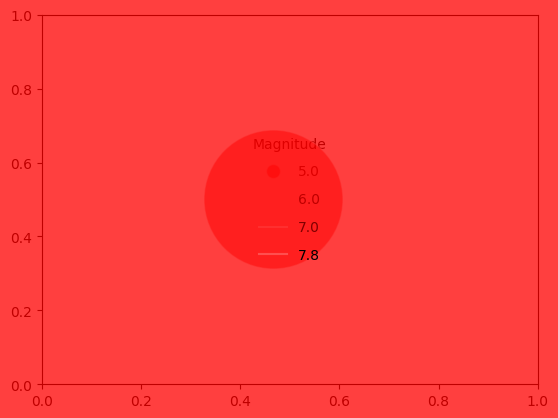

In [6]:
from matplotlib.lines import Line2D

# the four magnitudes in the legend
mags = np.array([5, 6, 7, quakes['mag'].max()])
marker_sizes = base_size * (10 ** (mags - base_magnitude))

def get_legend_elements(marker_sizes):
    # marker size for each magnitude
    marker_opts = dict(marker="o", color="w", markerfacecolor="red", alpha=0.5)
    legend_elements = [
        Line2D(
            [0],
            [i],
            label=mags[i],
            markersize=s,
            **marker_opts
        )
        for i, s in enumerate(marker_sizes)
    ]
    return legend_elements

fig, ax = plt.subplots()
legend_opts = dict(title="Magnitude", labelspacing=1, frameon=False)
ax.legend(handles=get_legend_elements(marker_sizes), **legend_opts, loc='center')

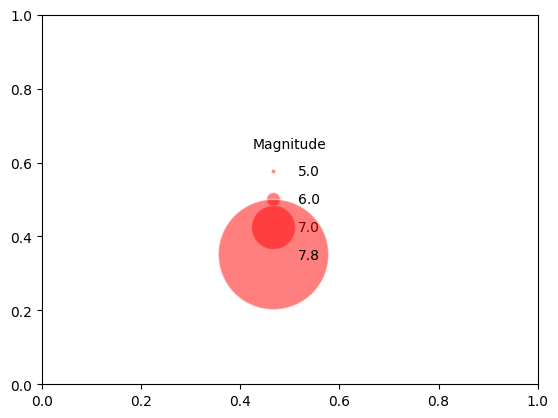

In [7]:
# marker size for each magnitude
marker_sizes = np.sqrt(base_size * (10 ** (mags - base_magnitude)))

fig, ax = plt.subplots()
ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center",
    title="Magnitude",
    labelspacing=1,
    frameon=False
)
plt.show()

In [8]:
fig, ax = plt.subplots(layout="constrained", figsize=(7,5))
ax.set(xlim=[minlongitude, maxlongitude], ylim=[minlatitude, maxlatitude])
ax.set_title("The April 2015 Nepal earthquake and its aftershocks")
cx.add_basemap(ax, crs=quakes.crs, zoom=8, source="CartoDB.Voyager")

points = ax.scatter(
    quakes["longitude"].iloc[0],
    quakes["latitude"].iloc[0],
    s=quakes["marker_size"].iloc[0],
    **points_opts
)

label = ax.text(
    0.25,
    0.95,
    quakes["time"].iloc[0].strftime("%Y-%m-%d %H:%M"),
    **label_opts
)

ax.legend(
    handles=get_legend_elements(marker_sizes),
    loc="center left",
    title="Magnitude",
    labelspacing=1,
    frameon=False,
    bbox_to_anchor=(1.05, 0.5), # place the legend to the right
)

ani = animation.FuncAnimation(
    fig=fig, func=update, frames=len(quakes), interval=600
)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15, bitrate=1800)
ani.save("animated-scatter-v2.gif", writer=writer)

plt.ioff
plt.close()